<a href="https://colab.research.google.com/github/AyushTyagi1610/Naive-Bayes/blob/main/text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
from itertools import chain

import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords', quiet=True)
# nltk.download('punkt', quiet=True)
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import numpy as np
import pandas as pd

import seaborn as sns

from sklearn import feature_extraction
from sklearn.metrics import confusion_matrix
from sklearn import model_selection as ms
from sklearn import naive_bayes
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

import string

Loading the dataset

In [72]:
from google.colab import files
uploaded = files.upload()

Saving website_classification.csv to website_classification (3).csv


In [73]:
import io
text_df = pd.read_csv(io.BytesIO(uploaded['website_classification.csv']))

In [74]:
text_df.head(5)

,Unnamed: 0,website_url,cleaned_website_text,Category
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


In [75]:
print('The shape of our data is:', text_df.shape)

The shape of our data is: (1408, 4)


Removing the redundant columns

In [76]:
del text_df['Unnamed: 0'], text_df['website_url']
text_df.head(5)

,cleaned_website_text,Category
0,official site good hotel accommodation big sav...,Travel
1,expedia hotel book sites like use vacation wor...,Travel
2,tripadvisor hotel book sites like previously d...,Travel
3,cheap flights search compare flights momondo f...,Travel
4,bot create free account create free account si...,Travel


In [77]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408 entries, 0 to 1407
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   cleaned_website_text  1408 non-null   object
 1   Category              1408 non-null   object
dtypes: object(2)
memory usage: 22.1+ KB


In [78]:
categories = list(text_df['Category'].unique())
categories

['Travel',
 'Social Networking and Messaging',
 'News',
 'Streaming Services',
 'Sports',
 'Photography',
 'Law and Government',
 'Health and Fitness',
 'Games',
 'E-Commerce',
 'Forums',
 'Food',
 'Education',
 'Computers and Technology',
 'Business/Corporate',
 'Adult']

### Data Cleaning

In [79]:
duplicate = text_df[text_df.duplicated()]
duplicate.shape[0]


33

Thus the dataset has duplicate entries and we need to remove these duplicate entries.

In [80]:
text_df = text_df.drop_duplicates()

In [81]:
text_df.drop_duplicates()

,cleaned_website_text,Category
0,official site good hotel accommodation big sav...,Travel
1,expedia hotel book sites like use vacation wor...,Travel
2,tripadvisor hotel book sites like previously d...,Travel
3,cheap flights search compare flights momondo f...,Travel
4,bot create free account create free account si...,Travel
...,...,...
1403,old nude women porn mature granny sex horny ol...,Adult
1404,bdsm cams bdsm chat bondage cams free bdsm vid...,Adult
1405,porno dvd online european porn dvd cheap adult...,Adult
1406,anal dream house anal dream house anal dream h...,Adult


In [82]:
text_df['Category'].value_counts()

Education                          114
Business/Corporate                 108
Travel                             106
Streaming Services                 104
E-Commerce                         101
Sports                             100
Games                               98
News                                92
Food                                92
Computers and Technology            90
Health and Fitness                  89
Photography                         87
Law and Government                  83
Social Networking and Messaging     79
Forums                              16
Adult                               16
Name: Category, dtype: int64

Number of unique rows by category

In [83]:
cat_unique_val = {}

for category in categories:
    mask = text_df['Category'] == category
    list_length = len(list(text_df[mask]['cleaned_website_text'].unique()))
    cat_unique_val.update({category: list_length})

    cat_unique_val

Sort dictionary in descending order

In [84]:
cat_unique_val_sorted = {}
sorted_keys = sorted(cat_unique_val, key=cat_unique_val.get)

for w in list(reversed(sorted_keys)):
    cat_unique_val_sorted[w] = cat_unique_val[w]
    
# cat_unique_val_sorted
cat_unique_val_sorted

{'Education': 114,
 'Business/Corporate': 108,
 'Travel': 106,
 'Streaming Services': 104,
 'E-Commerce': 101,
 'Sports': 100,
 'Games': 98,
 'Food': 92,
 'News': 92,
 'Computers and Technology': 90,
 'Health and Fitness': 89,
 'Photography': 87,
 'Law and Government': 83,
 'Social Networking and Messaging': 79,
 'Adult': 16,
 'Forums': 16}

In [85]:
text_df.shape

(1375, 2)

<h3>Text cleaning</h3>

<p>Removing stopwords and punctuation from <B><I>"cleaned_website_text" column</I></B></p>

In [86]:
stop_words = set(stopwords.words('english'))

In [87]:
regular_punct = list(string.punctuation)

<h3>According to title text in our dataframe column is cleared, but in any case we will aplly function to remove posssible stopwords and punctuation</h3>

In [88]:
text_df['cleaned_website_text']

0       official site good hotel accommodation big sav...
1       expedia hotel book sites like use vacation wor...
2       tripadvisor hotel book sites like previously d...
3       cheap flights search compare flights momondo f...
4       bot create free account create free account si...
                              ...                        
1403    old nude women porn mature granny sex horny ol...
1404    bdsm cams bdsm chat bondage cams free bdsm vid...
1405    porno dvd online european porn dvd cheap adult...
1406    anal dream house anal dream house anal dream h...
1407    world sex news daily sex news adult news eroti...
Name: cleaned_website_text, Length: 1375, dtype: object

In [89]:
def text_preprocessing(x):
    filtered_sentence = []
    word_tokens = word_tokenize(x)
    
    for w in word_tokens:
        if w not in chain(stop_words, regular_punct):
            # we make sure that all words are written in lowercase
            filtered_sentence.append(w.lower())
    
    # Converting a list of strings back to a string
    filtered_sentence = " ".join(filtered_sentence)
    return filtered_sentence

In [90]:
>>> import nltk
>>> nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [91]:
text_df['cleaned_website_text'] = text_df['cleaned_website_text'].apply(text_preprocessing)

In [92]:
text_df['cleaned_website_text']

0       official site good hotel accommodation big sav...
1       expedia hotel book sites like use vacation wor...
2       tripadvisor hotel book sites like previously d...
3       cheap flights search compare flights momondo f...
4       bot create free account create free account si...
                              ...                        
1403    old nude women porn mature granny sex horny ol...
1404    bdsm cams bdsm chat bondage cams free bdsm vid...
1405    porno dvd online european porn dvd cheap adult...
1406    anal dream house anal dream house anal dream h...
1407    world sex news daily sex news adult news eroti...
Name: cleaned_website_text, Length: 1375, dtype: object

<h3>Preprocessing the data</h3>

<h4>One of the simplest
methods of encoding text data is by word count: For each phrase, you count the
number of occurrences of each word within it. In scikit-learn, this is easily done using
CountVectorizer:</h4>

In [93]:
counts = feature_extraction.text.CountVectorizer()
X = counts.fit_transform(text_df['cleaned_website_text'].values)
X.shape

(1375, 59995)

In [94]:
y = text_df['Category'].values

Training the model using Naive Bayes Classifier

In [95]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=0)

In [96]:
model_naive = naive_bayes.MultinomialNB()
model_naive.fit(X_train, y_train)

MultinomialNB()

In [97]:
model_naive.score(X_train, y_train)

0.9818181818181818

In [98]:
model_naive.score(X_test, y_test)

0.9163636363636364

Therefore we have achieved an accuracy of 91% on our test dataset

<h4>Confusion matrix</h4>

In [99]:
confusion_matrix(y_test, model_naive.predict(X_test))

array([[ 3,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 17,  0,  3,  0,  0,  0,  0,  0,  1,  3,  0,  0,  0,  0,  1],
       [ 0,  0, 16,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0, 20,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2],
       [ 0,  0,  2,  0,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 18,  0,  0,  0,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 12,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 17,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0,  0, 24,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 23,  0,  0,  0,  0],
       [ 0,  1,  2,  0,  1,  0,  0,  0,  0,  0,  0,  0,  7,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

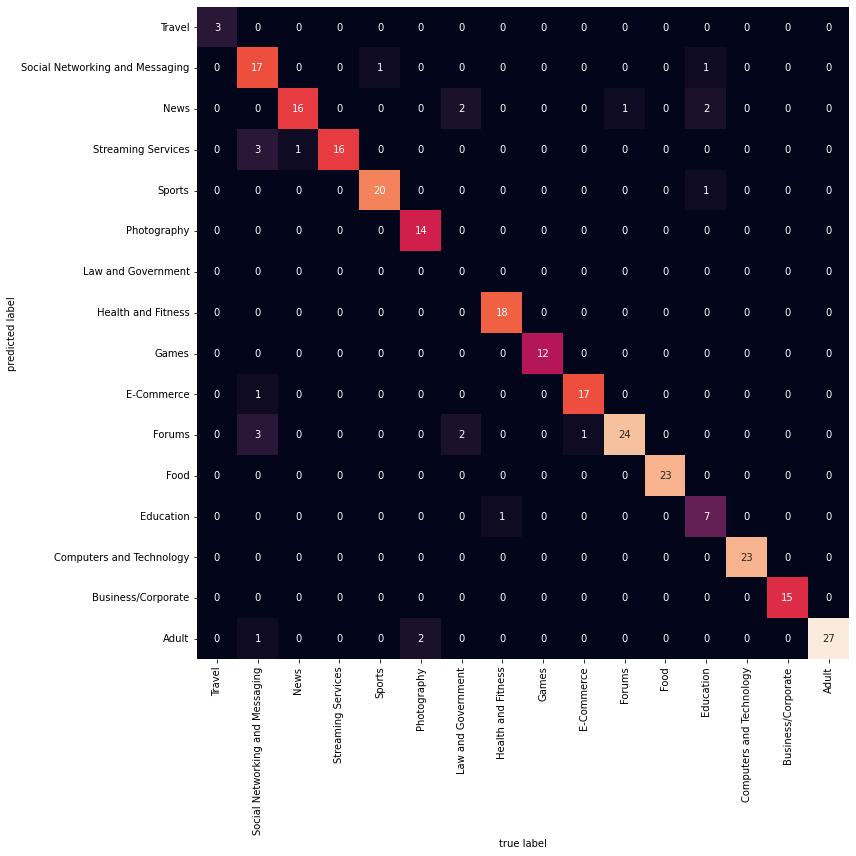

In [100]:
mat = confusion_matrix(y_test, model_naive.predict(X_test))
plt.figure(figsize=(18,12))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=categories,
            yticklabels=categories
           )
plt.xlabel('true label')
plt.ylabel('predicted label');